In [2]:
using Catlab, Catlab.WiringDiagrams, Catlab.Programs, Catlab.Graphics, Catlab.Graphics.Graphviz
using AlgebraicDynamics, AlgebraicDynamics.UWDDynam

using OrdinaryDiffEq, Plots

In [4]:
include("springs_animations.jl");

# Composing Springs in AlgebraicDynamics

This notebook shares examples of composing mechanical spring systems using AlgebraicDynamics.

## A single anchored spring

We define an open anchored spring as a resource sharer which exposes the mass and position of the spring's end point. 

In [5]:
function anchored_spring_dynamics(k)
  (u,p,t) -> begin 
      mass, pos, vel = u
      [0., vel, -k*pos/mass]
  end
end

anchored_spring(k) = ContinuousResourceSharer{Float64}(
    [:mass, :pos],               # interface
    3,                           # number of state vars
    anchored_spring_dynamics(k), # dynamics
    [1,2]                        # port map
);

After implementing an anchored spring with spring constant $k = 4$, we plot the solution to the ODE over time. As expected the position of the spring's endpoint oscillates, while the mass remains constant. 

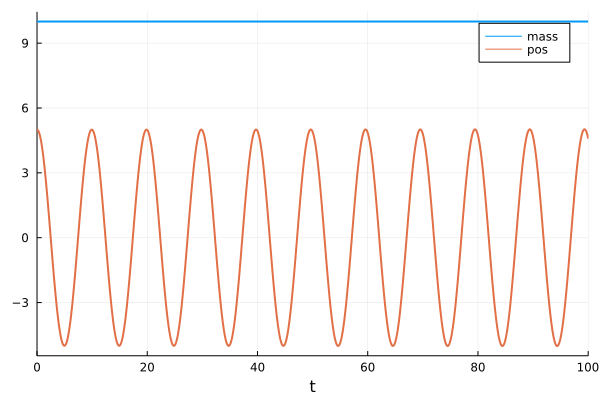

In [6]:
k = 4.0; mass = 10.0; p0 = 5.0;

spring = anchored_spring(k)

params = LVector(g=9.8)
u0 = [mass, p0, 0.]

tspan = (0, 100.0)
prob = ODEProblem(spring, u0, tspan, params)
sol_simple = solve(prob, Tsit5(), saveat=0.1)

plot(sol_simple, spring, lw = 2)

As our systems become more complex, these plots will be harder to read. Instead let's animate our spring! 

In [7]:
animate_spring(sol_simple, "orange", 0, 50, "simple_spring.gif")

Rendering frames... 100%|████████████████████████████████| Time: 0:00:03


"animations/simple_spring.gif"

The animations in this notebook were produced using [Javis](https://juliaanimators.github.io/Javis.jl/stable/) with help from [Akshay Shankar](https://20akshay00.github.io/)'s [PhysicsJavisAnim](https://20akshay00.github.io/PhysicsJavisAnim/) repository.

## A spring on earth 

For our first composite system, let's consider a spring on earth which consists of a simple anchored spring composed with a gravitational system that accounts for the effects of earth's gravity. First, we implement the arrangement of systems, which specifies how these two systems interact.

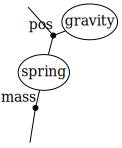

In [8]:
# The gravitational system
gravity = ContinuousResourceSharer{Float64}([:pos], 2, (u,p,t) -> [u[2], p.g], 1:1)

# The arrangement of systems
arrangement = @relation (mass, pos) begin
  spring(mass, pos)
  gravity(pos)
end

to_graphviz(arrangement, box_labels = :name, junction_labels = :variable)

We compose the simple anchored spring and gravitational systems according to the specified arrangement of systems using the `oapply` method.

In [9]:
spring_on_earth = oapply(arrangement, Dict(:spring => spring, :gravity => gravity))

ContinuousResourceSharer(ℝ^4 → ℝ^4) with 2 exposed ports

In [10]:
u0 = [mass, p0, 0., 0.]
prob = ODEProblem(spring_on_earth, u0, tspan, params)
sol_earth = solve(prob, Tsit5(), saveat=0.1);

Finally, we animate the results! As expected the spring on earth (left) ossillates with the same frequency as the simple anchored spring (right) but with a lower equilibrium point. 

In [11]:
h = 750
vid = Video(500, h)
nframes = length(sol_earth)
Background(1:nframes, ground)

# spring on earth 
spring_animation(sol_earth, 2,  75, Point(-100, -h/2), "orange", true, -(h/2 - 250))

# simple spring
spring_animation(sol_simple, 2, 75, Point(100, -h/2), "orange", true, -(h/2 - 250))

embed(vid, pathname = dir*"gravity.gif")

Rendering frames... 100%|████████████████████████████████| Time: 0:00:03


"animations/gravity.gif"

## Springs in Parallel

"Springs in parallel" refers to two springs which are attached to the same mass. We can construct springs in parallel as the composition of two anchored springs whose positions and masses are identified.

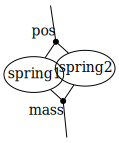

In [12]:
k1 = 10.0; k2 = 20.0
spring1 = anchored_spring(k1)
spring2 = anchored_spring(k2)

arrangement = @relation (mass, pos)  begin
  spring1(mass, pos)
  spring2(mass, pos)
end

to_graphviz(arrangement, box_labels = :name, junction_labels = :variable)

In [13]:
parallel_springs = oapply(arrangement, Dict(:spring1 => spring1, :spring2 => spring2))

ContinuousResourceSharer(ℝ^4 → ℝ^4) with 2 exposed ports

We can test our composite system by comparing the springs in parallel (left) to a spring with spring constant $k_1 + k_2$ (right). We expect these systems to behave identically.

In [14]:
u0 = [mass, p0, 0., 0.]
prob = ODEProblem(parallel_springs, u0, tspan, params)
sol_parallel = solve(prob, Tsit5(), saveat=0.1);

In [15]:
spring_compare = anchored_spring(k1 + k2)
prob = ODEProblem(spring_compare, [mass, p0, 0.], tspan, params)
sol_comparison = solve(prob, Tsit5(), saveat=0.1);

In [16]:
vid = Video(500, 500)
nframes = length(sol_parallel)
Background(1:nframes, ground)

# springs in parallel 
anchor = Point(-100, -250)
p = Object(1:nframes, (args...) -> object(O, "orange"), Point(0, 0))
act!(p, Action(1:nframes, solution_animation(sol_parallel, 2, anchor, true), Javis.translate()))
l1 = Object(1:nframes, (args...)->draw_spring(anchor-Point(-10,0), pos(p)-Point(-10,0), 25))
l2 = Object(1:nframes, (args...)->draw_spring(anchor-Point(10,0), pos(p)-Point(10,0), 50))

# comparison spring
spring_animation(sol_comparison, 2, 75, Point(100, -250), "orange")

embed(vid, pathname = dir*"parallel.gif")

Rendering frames... 100%|████████████████████████████████| Time: 0:00:02


"animations/parallel.gif"

## Springs in Series

"Springs in series" refers two springs where one endpoint of a free spring is identified with the endpoint of an anchored spring. We can construct springs in series as the composition of an anchored spring and a free spring with chosen positions and masses identified.

In [17]:
function free_spring_dynamics(k)
  (u,p,t) -> begin 
      top_mass, top_pos, top_vel, bot_mass, bot_pos, bot_vel = u
      [0., top_vel, -k*(top_pos - bot_pos)/top_mass, 0, bot_vel, -k*(bot_pos -top_pos)/bot_mass]
  end
end

free_spring(k) = ContinuousResourceSharer{Float64}(4, 6, free_spring_dynamics(k), [1,2,4,5]);

In [18]:
k1 = 10.0; k2 = 20.0

spring1 = anchored_spring(k1)
spring2 = free_spring(k2)

ContinuousResourceSharer(ℝ^6 → ℝ^6) with 4 exposed ports

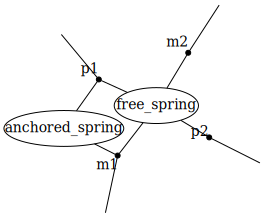

In [19]:
arrangement = @relation (m1, m2, p1, p2) begin
  anchored_spring(m1, p1)
  free_spring(m1, p1, m2, p2)
end

to_graphviz(arrangement, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))

In [20]:
series_springs = oapply(arrangement, Dict(:anchored_spring => spring1, :free_spring => spring2))

ContinuousResourceSharer(ℝ^7 → ℝ^7) with 4 exposed ports

In [21]:
m1 = 5.0; m2 = 5.0 
p1 = 4.0; p2 = 8.0

prob = ODEProblem(series_springs, [m1, p1, 0., 0., m2, p2, 0.], tspan, params)
sol_series = solve(prob, Tsit5(), saveat=0.1);

In [22]:
vid = Video(500, 600)
nframes = length(sol_series)
Background(1:nframes, ground)


#   springs in series 
p1 = Object(1:nframes, (args...) -> object(O, "orange"), Point(0, 0))
anchor = Point(0, -300)
act!(p1, Action(1:nframes, solution_animation(sol_series, 2, anchor, true), Javis.translate()))
l = Object(1:nframes, (args...)->draw_spring(anchor, pos(p1), 25))

p2 = Object(1:nframes, (args...) -> object(O, "orange"), Point(0, 0))
act!(p2, Action(1:nframes, solution_animation(sol_series, 6, anchor, true, 150.0), Javis.translate()))
l1 = Object(1:nframes, (args...)->draw_spring(pos(p1), pos(p2), 50))

embed(vid, pathname = dir*"series.gif")


Rendering frames... 100%|████████████████████████████████| Time: 0:00:02


"animations/series.gif"

To test our composite system, we can make the intermediate mass negligible (here, $m_1 = 0.01$). Then we compare this composite system (left) to an anchored spring with spring constant $\frac{k_1k_2}{k_1 + k_2}$ (right). We expect these systems to behave identically.

In [23]:
m1 = 0.01; m2 = 5.0 
p1 = 4.0; p2 = 8.0

prob = ODEProblem(series_springs, [m1, p1, 0., 0., m2, p2, 0.], tspan, params)
sol_series = solve(prob, Tsit5(), saveat=0.1);

spring_compare = anchored_spring(k1*k2/(k1 + k2))
prob = ODEProblem(spring_compare, [m1+m2, p2, 0.], tspan, params)
sol_compare = solve(prob, Tsit5(), saveat=0.1);

In [24]:
vid = Video(500, 600)
nframes = length(sol_series)
Background(1:nframes, ground)

#   springs in series 
p1 = Object(1:nframes, (args...) -> object(O, "orange", 5), Point(0, 0))
anchor = Point(-100, -300)
act!(p1, Action(1:nframes, solution_animation(sol_series, 2, anchor, true), Javis.translate()))
l1 = Object(1:nframes, (args...)->draw_spring(anchor, pos(p1), 25))

p2 = Object(1:nframes, (args...) -> object(O, "orange"), Point(0, 0))
act!(p2, Action(1:nframes, solution_animation(sol_series, 6, anchor, true, 150.0), Javis.translate()))
l2 = Object(1:nframes, (args...)->draw_spring(pos(p1), pos(p2), 50))

# comparison spring
spring_animation(sol_compare, 2, 50, Point(100, -300), "orange", true, 150)


embed(vid, pathname = dir*"series2.gif")


Rendering frames... 100%|████████████████████████████████| Time: 0:00:03


"animations/series2.gif"